- What Amenities show a bigger price difference?
- Do "better" hosts charge more?
- What are the city areas with the highest/ lower average prices? Is that related to different listing characteristics?

In [1]:
import pandas as pd
import numpy as np

import re

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={"figure.figsize":(15, 10)})

In [3]:
df = pd.read_csv('data/listings.csv.gz', compression='gzip')

In [4]:
with pd.option_context('display.max_columns',None):
    display(df.head())

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,53344884,https://www.airbnb.com/rooms/53344884,20220921172238,2022-09-22,city scrape,Suntuoso apartamento em Copacabana posto 6,suntuoso apartamento de frente para o mar <br ...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,431412286,https://www.airbnb.com/users/show/431412286,Carlos Henrique,2021-11-11,NaN,NaN,within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/f4bec...,https://a0.muscache.com/im/pictures/user/f4bec...,NaN,10.0,10.0,"['email', 'phone']",t,t,NaN,Copacabana,NaN,-22.98299,-43.18904,Entire condo,Entire home/apt,6,NaN,4.5 baths,3.0,5.0,"[""Air conditioning"", ""Washer"", ""Security camer...","$3,500.00",3,365,3,3,365,365,3.0,365.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,10,8,2,0,NaN
1,7801456,https://www.airbnb.com/rooms/7801456,20220921172238,2022-09-22,city scrape,Ipanema Vieira Souto - Linda Vista,Flat luxuoso com a melhor localização do Rio d...,"Ipanema é considerado o berço do rio, cheio de...",https://a0.muscache.com/pictures/99276394/dc9c...,40650139,https://www.airbnb.com/users/show/40650139,Carlos Alberto,2015-08-05,"Rio de Janeiro, Brazil","22 anos, Brasileiro, Solteiro, residencia fixa...",a few days or more,13%,100%,f,https://a0.muscache.com/im/users/40650139/prof...,https://a0.muscache.com/im/users/40650139/prof...,Ipanema,6.0,6.0,"['email', 'phone']",t,t,"Rio de Janeiro, Brazil",Ipanema,NaN,-22.98723,-43.20452,Entire serviced apartment,Entire home/apt,4,NaN,2 baths,2.0,3.0,"[""Cable TV"", ""Air conditioning"", ""Fire extingu...","$5,000.00",2,900,2,2,900,900,2.0,900.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,5,5,0,0,NaN
2,14333905,https://www.airbnb.com/rooms/14333905,20220921172238,2022-09-22,city scrape,Casa compartilhada,"A 15 min. do complexo esportivo de Deodoro, Ca...",NaN,https://a0.muscache.com/pictures/15235501-16c4...,87749071,https://www.airbnb.com/users/show/87749071,Lindenberg,2016-08-03,"Rio de Janeiro, Brazil",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/409ec...,https://a0.muscache.com/im/pictures/user/409ec...,NaN,1.0,1.0,"['email', 'phone']",t,f,NaN,Pavuna,NaN,-22.80869,-43.38642,Entire home,Entire home/apt,12,NaN,1 bath,2.0,4.0,"[""Cable TV"", ""Air conditioning"", ""Hair dryer"",...",$681.00,1,1125,1,1,1125,1125,1.0,1125.0,NaN,t,30,60,90,365,2022-09-22,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
3,44708736,https://www.airbnb.com/rooms/44708736,20220921172238,2022-09-22,city scrape,Aluguel de Lancha no Rio de Janeiro,Iate Intermarine 440 Full Gold c/ Fly p/ até 1...,A Marina da Glória fica no bairro do Flamengo ...,https://a0.muscache.com/pictures/210e9

# Sanity Checks

## Empty Values

In [5]:
col_na_proportion = df.isna().mean()

In [6]:
col_na_proportion[col_na_proportion > 0.1].round(3) # Arbitrary minimum NA boundary of 10% of rows

neighborhood_overview           0.473
host_location                   0.182
host_about                      0.515
host_response_time              0.133
host_response_rate              0.133
host_acceptance_rate            0.134
host_neighbourhood              0.407
neighbourhood                   0.473
neighbourhood_group_cleansed    1.000
bathrooms                       1.000
calendar_updated                1.000
first_review                    0.266
last_review                     0.266
review_scores_rating            0.266
review_scores_accuracy          0.274
review_scores_cleanliness       0.274
review_scores_checkin           0.274
review_scores_communication     0.274
review_scores_location          0.274
review_scores_value             0.274
license                         1.000
reviews_per_month               0.266
dtype: float64

- Some columns are complely empty
- About half of the listings don't have any description about the host
- Approx. 1 out of 4 listings don't have a review

- Bathrooms columns was actually replaced with bathrooms_text

## Subsetting to relevant features

In [7]:
# Subsetting to columns that might be relevant for us to work with
# Ignoring relevant columns that are completely empty (ex: bathrooms)
subset_cols = ['id',
                'listing_url',
                'last_scraped',
                'source',
                'name',
                'description',
                'host_about',
                'host_response_time',
                'host_response_rate',
                'host_is_superhost',
                'host_has_profile_pic',
                'host_identity_verified',
                'neighbourhood_cleansed',
                'property_type',
                'room_type',
                'accommodates',
                'bathrooms_text',
                'bedrooms',
                'beds',
                'amenities',
                'price',
                'minimum_nights',
                'maximum_nights']

In [8]:
df_subset = df[subset_cols].copy() # Generating a copy to avoid object reference problems when creating new cols

In [9]:
df_subset.isna().mean()

id                        0.000000
listing_url               0.000000
last_scraped              0.000000
source                    0.000000
name                      0.000721
description               0.031366
host_about                0.515019
host_response_time        0.133088
host_response_rate        0.133088
host_is_superhost         0.000265
host_has_profile_pic      0.000190
host_identity_verified    0.000190
neighbourhood_cleansed    0.000000
property_type             0.000000
room_type                 0.000000
accommodates              0.000000
bathrooms_text            0.001896
bedrooms                  0.049723
beds                      0.008951
amenities                 0.000000
price                     0.000000
minimum_nights            0.000000
maximum_nights            0.000000
dtype: float64

## Subset - Type handling

In [10]:
df_subset.dtypes

id                          int64
listing_url                object
last_scraped               object
source                     object
name                       object
description                object
host_about                 object
host_response_time         object
host_response_rate         object
host_is_superhost          object
host_has_profile_pic       object
host_identity_verified     object
neighbourhood_cleansed     object
property_type              object
room_type                  object
accommodates                int64
bathrooms_text             object
bedrooms                  float64
beds                      float64
amenities                  object
price                      object
minimum_nights              int64
maximum_nights              int64
dtype: object

### Dates

In [11]:
# Handling scraped date
df_subset['last_scraped'] = pd.to_datetime(df_subset['last_scraped'], yearfirst=True)

In [12]:
# Check if dataset contains old entries - They might not be relevant
df_subset['last_scraped'].value_counts()

2022-09-22    20849
2022-09-21     5462
2022-09-23       54
2022-10-02        1
Name: last_scraped, dtype: int64

### Prices

In [13]:
# Price

# Do all prices start with '$'?
print(df_subset['price'].shape[0] == df_subset['price'].str.startswith('$').sum())

True


In [14]:
df_subset['price'] = df_subset['price'].str[1:]

df_subset['price'] = df_subset['price'].str.replace(',','', regex=True)

df_subset['price'] = df_subset['price'].astype(float)

### Amenities

In [15]:
df_subset['amenities'].head()

0    ["Air conditioning", "Washer", "Security camer...
1    ["Cable TV", "Air conditioning", "Fire extingu...
2    ["Cable TV", "Air conditioning", "Hair dryer",...
3    ["Single level home", "Wifi \u2013 30 Mbps", "...
4    ["Air conditioning", "First aid kit", "Iron", ...
Name: amenities, dtype: object

In [16]:
# Are amenities strings?
(df_subset['amenities'].apply(type) == str).all()

True

Amenities are actually strings instead of lists. This needs fixing.\
Also, since it is a whole string, the whitespaces before the quotes will stay there. They need to be fixed too.\
To fix the whitespaces I will be using a function, but it could be done via RegEx as well.\
Also, some not parsed unidecode characters get into the dataset. They will be removed since they probably won't be word characters

In [17]:
def strip_tokens(token_list):

    return [token.strip() for token in token_list]

def replace_unidecode(token_list):

    ''' Replaces non-parsed unidecode chars with single Whitespace.
        If simply replaced by empty strings, will generate a double whitespace
        '''

    return [re.sub(r'\s+', ' ', re.sub(r'\\u\d+','', token)) for token in token_list]

In [18]:
# The Brackets and quotes will break a simple split function. They need to be treated beforehand.
df_subset['amenities'] = df_subset['amenities'].str.replace('\[|\]|\"','', regex = True)\
                                                .str.split(',')\
                                                .apply(strip_tokens)\
                                                .apply(replace_unidecode)

In [19]:
display(df_subset['amenities'].head())

display(df_subset['amenities'][0]) # Example

0    [Air conditioning, Washer, Security cameras on...
1    [Cable TV, Air conditioning, Fire extinguisher...
2    [Cable TV, Air conditioning, Hair dryer, Iron,...
3    [Single level home, Wifi 30 Mbps, Dedicated wo...
4    [Air conditioning, First aid kit, Iron, Essent...
Name: amenities, dtype: object

['Air conditioning',
 'Washer',
 'Security cameras on property',
 'Wifi',
 'Long term stays allowed',
 'Kitchen',
 'TV']

## Bathrooms

In [20]:
df_subset.bathrooms_text

0            4.5 baths
1              2 baths
2               1 bath
3              2 baths
4               1 bath
             ...      
26361    1 shared bath
26362           1 bath
26363           1 bath
26364           1 bath
26365           1 bath
Name: bathrooms_text, Length: 26366, dtype: object

In [21]:
print('Entries that contain "bath":',df_subset[df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)].shape[0])

print('Total Entries:',df_subset.shape[0])

Entries that contain "bath": 26316
Total Entries: 26366


There are 50 entries that don't contain the any word with 'bath' in it

In [22]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)]['bathrooms_text'].isna().sum()

50

The different entries are empty are because they are NaN values

In [23]:
df_subset[~df_subset['bathrooms_text'].str.contains(r'bath[s]?', na = False)][['name','description']].sample(10, random_state=123)

,name,description
479,Praia da Macumba Recreio,"<b>The space</b><br />Apartameno pequeno,1 Qto..."
603,Cozy room @ Copacabana - Posto 06,<b>The space</b><br />Excellent apartment near...
2056,Maracana - apartamento a 200 metros,Excelente apartamento a 200 metros do MARACANÃ...
19656,Mansão INCRÍVEL no meio da natureza para EVENTOS,NaN
661,ótimo Quarto em Santa Teresa - RJ,<b>The space</b><br />Casa ampla em Santa Tere...
89,Apartamento Moderno e confortavel,"Seja bem vindo a esse apartamento moderno, con..."
14651,Américas Copacabana Hotel,NaN
600,Vinicius,"tarifa baixa temporada, mínimo 5 noites<br /><..."
869,Ipanema 602,"<b>The space</b><br />linen not included, on r..."
348,BAND NEW APT COPACABANA,<b>The space</b><br />APT JUST RENOVATED! ALL ...


From the descriptions, it doesn't look like these are listings that don't have bathrooms. Imputing with some value might be more realistic.\
Also, there are not many listings without the number of bathrooms. It shouldn't impact us much

After some inspections there are some key tokens that will be removed, for simplicity:

- Bath(s)
- Shared
- Private

In [24]:
df_subset['bathrooms_text'].str.contains('shared').sum()

3156

In [25]:
df_subset['bathrooms_text'].str.contains('private').sum()

1727

In [26]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'bath[s]?|shared|private','',case = False,regex = True)\
                                                            .str.strip()

In [27]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array(['half-', 'Half-'], dtype=object)

In [28]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].str.replace(r'half-','0.5',case = False,regex = True)\
                                                            .str.strip()

In [29]:
df_subset[(df_subset['bathrooms_text'].notnull()) & (df_subset['bathrooms_text'].str.contains(r'[A-Za-z]+', regex = True))]['bathrooms_text'].unique()

array([], dtype=object)

In [30]:
df_subset['bathrooms_text'] = df_subset['bathrooms_text'].astype(float)

# Analysis

## Amenities analysis

- What are the Amenities that might have the biggest price differences

Let's create a quick corpus for our data and see if we can keep only some key amenities or come up with other fixes.\
I'm specially interested in the Wifi amenity that contains internet speed. Wifi available or not should be counted regardless of speed. This, of course, excluding specific cases such as well-equipped, remote-work ready AirBnBs

In [31]:
amenities_corpus = df_subset['amenities'].explode()

In [32]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  3260


In [33]:
# Looking specifically into wifi
len(amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique())

401

In [34]:
# Samples
amenities_corpus[amenities_corpus.str.contains('wifi', case = False)].unique()[0:10]

array(['Wifi', 'Wifi 30 Mbps', 'Pocket wifi', 'Wifi 28 Mbps',
       'Fast wifi 101 Mbps', 'Fast wifi 663 Mbps', 'Fast wifi 55 Mbps',
       'Fast wifi 157 Mbps', 'Fast wifi 66 Mbps', 'Fast wifi 542 Mbps'],
      dtype=object)

There are a lot of possible entries for wifi, we'll replace them all for simplicity.\
Will do it in two categories: Fast and Regular Wifi

In [35]:
reg_wifi_pat = r'(?<!Fast\s)wifi'

fast_wifi_pat = r'(?<=Fast\s)wifi'

In [36]:
reg_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(reg_wifi_pat, case = False)].unique())

fast_wifi_repl_str = '|'.join(amenities_corpus[amenities_corpus.str.contains(fast_wifi_pat, case = False)].unique())

In [37]:
amenities_corpus = amenities_corpus.str.replace(reg_wifi_repl_str,'Wifi', regex = True)\
                                    .str.replace(fast_wifi_repl_str,'Fast Wifi', regex = True)

In [38]:
print('Unique Amenities: ',amenities_corpus.nunique())

Unique Amenities:  2910


## Obtaining the most usual amenities

The most frequent amenities are those that are present in a big part of the listings. The total count of an amenity means the amount of appearances of that amenity on listings

In [39]:
amenities_pareto = amenities_corpus.value_counts().to_frame()

In [40]:
amenities_pareto.rename(columns = {'amenities':'listings_count'}, inplace = True)

In [41]:
# Getting proportion of amenities in listings
amenities_pareto['listings_proportion'] = amenities_pareto['listings_count'] / df_subset.shape[0]

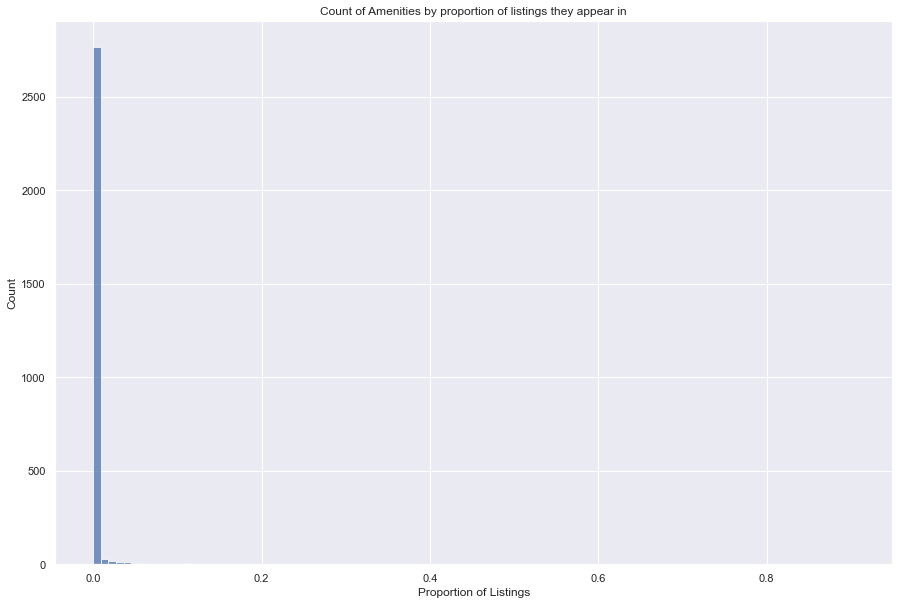

In [42]:
sns.histplot(data = amenities_pareto, x = 'listings_proportion', bins = 100)

plt.title('Count of Amenities by proportion of listings they appear in')

plt.xlabel('Proportion of Listings')

plt.show()

In [43]:
for proportion in np.arange(0,1.1,.1):

    print(f'Amount of amenities that occur in at least {proportion:.2%} of all listings:',amenities_pareto[amenities_pareto['listings_proportion'] >= proportion].shape[0])
    

Amount of amenities that occur in at least 0.00% of all listings: 2910
Amount of amenities that occur in at least 10.00% of all listings: 56
Amount of amenities that occur in at least 20.00% of all listings: 34
Amount of amenities that occur in at least 30.00% of all listings: 23
Amount of amenities that occur in at least 40.00% of all listings: 18
Amount of amenities that occur in at least 50.00% of all listings: 13
Amount of amenities that occur in at least 60.00% of all listings: 9
Amount of amenities that occur in at least 70.00% of all listings: 4
Amount of amenities that occur in at least 80.00% of all listings: 3
Amount of amenities that occur in at least 90.00% of all listings: 2
Amount of amenities that occur in at least 100.00% of all listings: 0


1. There might be a lot of unique values because of an open format of the field. 
2. Of all the possible amenities, only 13 appear on more than half of the listings. If we make a cut as small as 10% we can already indetify a relevant subset of amenities

## Analyzing the top amenities

Making the 10% cut, we are going to evaluate the price difference for the presence or absence of the amenities

In [93]:
list_key_amenities = amenities_pareto[amenities_pareto['listings_proportion'] >= 0.5].index.values

In [94]:
df_amenities = df_subset[['id','price','amenities']].copy()

In [95]:
for amenity in list_key_amenities:

    amen_func = lambda am_list: amenity in am_list

    df_amenities[f'am_{amenity}'] = df_amenities['amenities'].apply(amen_func)

In [96]:
df_amenities.head()

,id,price,amenities,am_Wifi,am_Kitchen,am_Long term stays allowed,am_Essentials,am_Hangers,am_Iron,am_Hot water,am_Air conditioning,am_Dishes and silverware,am_Elevator,am_Cooking basics,am_Refrigerator,am_Bed linens
0,53344884,3500.0,"[Air conditioning, Washer, Security cameras on...",True,True,True,False,False,False,False,True,False,False,False,False,False
1,7801456,5000.0,"[Cable TV, Air conditioning, Fire extinguisher...",True,True,True,True,False,False,True,True,False,True,False,False,False
2,14333905,681.0,"[Cable TV, Air conditioning, Hair dryer, Iron,...",True,True,True,False,False,True,False,True,False,False,False,False,False
3,44708736,8999.0,"[Single level home, Wifi 30 Mbps, Dedicated wo...",False,True,False,True,True,False,True,False,True,False,True,False,True
4,35351763,500.0,"[Air conditioning, First aid kit, Iron, Essent...",True,True,False,True,False,True,False,True,False,False,False,False,False


In [97]:
am_cols = [col for col in df_amenities.columns if col.startswith('am_')]

In [98]:
dict_am_prices = {}

dict_am_prices['am_Wifi'] = df_amenities.groupby('am_Wifi')['price'].mean().to_dict()

In [99]:
dict_am_prices

{'am_Wifi': {False: 773.156005788712, True: 783.938763039588}}

In [100]:
re.sub('am_','','am_Wifi')

'Wifi'

In [101]:
dict_am_prices = {}

for col in am_cols:

    name = re.sub('am_','',col)

    dict_am_prices[name] = df_amenities.groupby(col)['price'].agg(['mean','count'])\
                                                                .to_dict()


In [102]:
dict_am_prices

{'Wifi': {'mean': {False: 773.156005788712, True: 783.938763039588},
  'count': {False: 3455, True: 22911}},
 'Kitchen': {'mean': {False: 904.3426707597852, True: 769.164898989899},
  'count': {False: 2606, True: 23760}},
 'Long term stays allowed': {'mean': {False: 950.6460481099656,
   True: 759.294496006907},
  'count': {False: 3201, True: 23165}},
 'Essentials': {'mean': {False: 1197.444245773732, True: 656.2480459087761},
  'count': {False: 6152, True: 20214}},
 'Hangers': {'mean': {False: 921.8906502749919, True: 706.9199672380506},
  'count': {False: 9273, True: 17093}},
 'Iron': {'mean': {False: 967.8883622428399, True: 670.7899088145897},
  'count': {False: 9916, True: 16450}},
 'Hot water': {'mean': {False: 1149.7749551703528, True: 556.7512248897599},
  'count': {False: 10038, True: 16328}},
 'Air conditioning': {'mean': {False: 560.839902200489,
   True: 922.9593581562481},
  'count': {False: 10225, True: 16141}},
 'Dishes and silverware': {'mean': {False: 1127.556726173056